## QR分解

### Householder变换

对于实向量 $x,y\in \mathbb R^n$, 若 $\Vert x\Vert_2 = \Vert y\Vert_2$, 则存在正交矩阵 $Q$ 使得 $Qx = y$.

实际上, 取 $v = \frac{x-y}{2\sqrt{(x-y)^Tx}}$, $Q = I - 2vv^T$. 

则 $$Qx = x - 2vv^Tx = x - 2v(v^Tx) = y$$
且 $v^Tv = \frac{x^Tx+y^Ty-2x^Ty}{2\sqrt{(x-y)^Tx}} = 1$, 
$$Q^TQ = (I-2vv^T)(I-2vv^T) = I - 4vv^T + 4vv^Tvv^T = I$$
说明 $Q$ 是正交矩阵.

实际上, 几何意义上, 变换 $Q$ 是一个反射(对称/镜像), 因为 $Q^2 = Q^TQ = I$. 

称 $Q$ 为 Householder 矩阵, 向量 $v$ 为 Householder 向量. 

由于 $v$ 是单位向量, 也可以写成 $v = \frac{x-y}{\Vert x-y\Vert_2}$, 或
$Q = I - \frac{2}{\Vert x-y\Vert_2^2}(x-y)^T(x-y)$.

对于复向量 $x,y\in \mathbb C^n$, 若 $\Vert x\Vert_2 = \Vert y\Vert_2$, 则存在单位向量 $v$ 使得 $(I-2vv^*)x = y$ 当且仅当 $y^*x\in \mathbb R$.

证: 

必要性: $y^*x = x^*(I-2vv^*)x = \Vert x\Vert_2^2 - 2|v^*x|^2\in \mathbb R$

充分性: $y^*x\in \mathbb R$, 取 $v = e^{i\theta}\frac{x-y}{2\sqrt{(x-y)^*x}}$ 即可.

### Householder QR

对于矩阵 $A$ 首先找到 Householder 矩阵 $I-2v_1v_1^*$ 使得 $I-2v_1v_1^*$ 将 $A$ 的第一列变成除了第一个元素, 其余为零的向量. 那么, 在这个 Householder 矩阵作用下, 

$$(I-2v_1v_1^*)\left[\begin{matrix} \times  &  \times  & \dotsc &  \times  \\
 \times  & \times  &\dotsc &  \times \\
\vdots &\vdots &\ddots & \vdots \\
 \times  & \times  &\dotsc & \times \end{matrix}\right]
\rightarrow \left[\begin{matrix} \times  &  \times  & \dotsc &  \times  \\
 & \times  &\dotsc &  \times \\
 &\vdots &\ddots & \vdots \\
  & \times  &\dotsc & \times \end{matrix}\right]
$$

当然上面的矩阵的后 $n-1$ 列也会变化. 再对右下 $(n-1)\times (n-1)$ 矩阵处理, 找到一个 $(n-1)$ 维的 Householder 向量 $v_2$ 使得第二列除了第一个和第二个元素以外, 其余都是零. 即
$$\left[\begin{matrix}1 & \\ \ & I-2v_2v_2^*\end{matrix}\right]
\left[\begin{matrix} \times  &  \times  & \dotsc &  \times  \\
 & \times  &\dotsc &  \times \\
 &\vdots &\ddots & \vdots \\
  & \times  &\dotsc & \times \end{matrix}\right]
\rightarrow \left[\begin{matrix} \times  &  \times  & \dotsc &  \times  \\
 &\times    &\dotsc &  \times \\
 & &\ddots & \vdots \\
  &   &\dotsc & \times \end{matrix}\right]$$

如此继续, 最终得到
$$\left[\begin{matrix}I_{n-1} & \\ \ & I-2v_nv_n^*\end{matrix}\right]\dotsm
\left[\begin{matrix}I_{1} & \\ \ & I-2v_2v_2^*\end{matrix}\right]
(I-2v_1v_1^*)A = R.$$

左边都是酉矩阵, 移项到右边自然得到 $A$ 的 $QR$ 分解.

<font color=red>必须注意</font>, Householder 变换无论左乘还是右乘都有便捷的方式:
$$(I-2vv^*)P = P - 2v(v^*P)$$

$$P(I - 2vv^*) = P - 2(Pv)v^*$$

从上面两式可以看出, Householder 变换的代码并不需要真的计算 $I-2vv^*$ 再做矩阵-矩阵乘法, 而是可以用矩阵-向量乘法替代. 单次 Householder 变换的时间复杂度为 $O(n^2)$. 

因此上述 $QR$ 分解的总时间复杂度为 $O(n^3)$.

In [2]:
import numpy as np
import math
from numba import jit

@jit(nopython=True)
def HouseholderVector(A):
    squarelength = np.dot(A[1:].conj(), A[1:])
    if squarelength == 0: # 已经完成了,不需要做变换
        return A, A, 1

    # 对于复向量 x, 需要确定向量 y, 使得 y 的第一个分量模长等于 x 的范数
    # 且 y,x 的内积是实数
    # 才有 Householder变换 Qx = y
    normal     = A.copy()
    rotation   = A[0]/abs(A[0]) if A[0] != 0 else 1. 
    normal[0] = (abs(A[0]) + math.sqrt(max((squarelength + A[0] * A[0].conjugate()).real,0))) * rotation

    # 用返回两个不同模长的向量替代正规化
    normal2 = normal.conj() * ( -2. /(squarelength + normal[0] * normal[0].conjugate()))
    
    return normal, normal2, 0

# Householder 作用在矩阵左侧
@jit(nopython=True)
def leftHouse(A,vectors):
    normal , normal2 , flag = vectors
    if flag:
        return 
    tmp = normal2 @ A
    n = tmp.shape[0]
    # 这里做原地修改而非生成 n*n 矩阵才能不损失效率 , 亦即 CGEMM
    # 为了使用 for 循环, 额外用到 jit 加速, 这样做比 numpy 生成 n*n 矩阵后再修改快很多倍
    for i in range(normal.shape[0]):
        for j in range(n):
            A[i,j] += normal[i]*tmp[j]

# Householder 作用在矩阵右侧
@jit(nopython=True)
def rightHouse(A,vectors):
    normal , normal2 , flag = vectors
    if flag:
        return 
    tmp = A @ normal
    n = normal2.shape[0]
    for i in range(tmp.shape[0]):
        for j in range(n):
            A[i,j] += tmp[i]*normal2[j]

In [28]:
def HouseholderQR(A,copy=1):
    if copy: A = A.copy()
    n = A.shape[1]
    Q = np.eye(A.shape[0],dtype=A.dtype)
    for k in range(n):
        v = HouseholderVector(A[k:,k])
        leftHouse(A[k:,k:],v)
        rightHouse(Q[:,k:],v)
        A[k+1:,k] = 0
    return Q , A

m , n = 200, 100  # m >= n
np.random.seed(0)
A = np.random.random((m,n)) - 0.5 + np.random.random((m,n))*1j - 0.5j
Q , R = HouseholderQR(A)
print('Orthogonality Loss =',np.linalg.norm(Q.T.conj() @ Q - np.eye(m)))
print('Residual =',np.linalg.norm(A - Q @ R))

Orthogonality Loss = 1.461749019081143e-14
Residual = 4.942814106352741e-14


Householder QR 算法的 $n$ 个Householder 矩阵还可以反向累计 (backward accumulation) 减少运算量, 见 [1] 5.1.6.

### Givens 变换

Householder 变换是反射, 而 Givens 变换则是旋转. 若 $a,b\in \mathbb R$, 则存在 $\theta$ 使得
$$\left[\begin{matrix}cos\theta & sin\theta \\ -sin\theta & cos\theta \end{matrix}\right]
\left[\begin{matrix}a \\ b\end{matrix}\right] = \left[\begin{matrix}\pm \sqrt{a^2+b^2} \\ 0\end{matrix}\right].$$

其中,
$cos\theta = \pm \frac{a}{\sqrt{a^2+b^2}}$, $sin\theta = \pm \frac{b}{\sqrt{a^2+b^2}}$.

为了提高数值精度, 代码中应该按如下方式计算:

若 $b = 0$, 则 $cos\theta = 1$, $sin\theta = 0$. 

若 $|b|>|a|$, 则 $cot\theta = \frac{a}{b}$, $sin\theta = \frac{1}{\sqrt{1+cot^2\theta}}$, $cos\theta = cot\theta sin\theta$. 

若 $|a|>|b|>0$, 则 $tan\theta = \frac{b}{a}$, $cos\theta = \frac{1}{\sqrt{1+tan^2\theta}}$, $sin\theta = tan\theta cos\theta$. 

<br>

若在复数域 $a,b\in \mathbb C$, 则

$$\left[\begin{matrix}cos\theta & sin\theta e^{i\phi} \\ -sin\theta  e^{-i\phi} & cos\theta \end{matrix}\right]
\left[\begin{matrix}a \\ b\end{matrix}\right] = \left[\begin{matrix} re^{i\alpha} \\ 0\end{matrix}\right].$$

其中, $\phi$ 是 $\frac{a}{b}$ 的辐角, $tan\theta = \left| \frac{b}{a}\right|$. 等式右侧 $\alpha $ 为 $a$ 的辐角, $r=\sqrt{|a|^2+|b|^2}$.
<br>

相比于 Householder QR, Givens变换需要做更多次, 所以更慢. 但是若矩阵是稀疏的 (已有很多零), 使用 Givens 能尽量避免破坏这些零, 从而可以使用更少的 Givens变换, 效率可能更高.

In [44]:
def GivensAngle(a,b):
    if b == 0: return 1, 0
    if abs(a) > abs(b):
        tant = b / a
        cost = 1. / math.sqrt(1 + (tant*tant.conjugate()).real)
        sint = cost * tant.conjugate()
    else:
        cott = a / b
        cost = abs(cott) / math.sqrt(1 + (cott*cott.conjugate()).real)
        sint = cost / cott.conjugate()
    return cost, sint

def Givens(a,b,angle):
    cost , sint = angle
    tmp = cost * a + sint * b
    b[:] = (-sint).conjugate() * a + cost * b
    a[:] = tmp

def GivensQR(A,copy=1):
    if copy: A = A.copy()
    m , n = A.shape
    Q = np.eye(m,dtype=A.dtype)
    for i in range(n):
        for j in range(i+1,m):
            angle = GivensAngle(A[i,i],A[j,i])
            Givens(A[i,i:],A[j,i:],angle)
            Givens(Q[:,i],Q[:,j],angle)
        A[i+1:,i] = 0
    return Q.conj() , A

m , n = 200, 100  # m >= n
np.random.seed(0)
A = np.random.random((m,n)) - 0.5 + np.random.random((m,n))*1j - 0.5j
Q , R = GivensQR(A)
print('Orthogonality Loss =',np.linalg.norm(Q.T.conj() @ Q - np.eye(m)))
print('Residual =',np.linalg.norm(A - Q @ R))

Orthogonality Loss = 3.164744597839578e-14
Residual = 1.2840478585330373e-13


### Gram-Schmidt 正交化

设矩阵 $A = [ v_1\ v_2\ \dotsc \ v_n]$, 其中 $v_i$ 为列向量. 设 

$$[ v_1\ v_2\ \dotsc \ v_n] = A = QR = [q_1\ q_2\ \dotsc \ q_n]\left[\begin{matrix} \times  &  \times  & \dotsc &  \times  \\
 & \times  &\dotsc &  \times \\
&  &\ddots & \vdots \\
  &   &  & \times \end{matrix}\right].$$

可见 $v_1$ 是 $q_1$ 的线性组合, $v_2$ 是 $q_1,q_2$ 的线性组合, ..., $v_k$ 是 $q_1,\dotsc ,q_k$ 的线性组合. 因此若已经求出 $q_1,\dotsc ,q_{k-1}$, 则可以令 $q_k$ 为 $v_1$ 在与 $q_1,\dotsc ,q_{k-1}$ 均垂直的方向的单位分量.

$$q_k = \frac{ v_k - q_1(q_1^*v_k) - \dotsc - q_{k-1}(q_{k-1}^*v_k)}{\rho}

=\frac{v_k - Q_{1:n,1:k-1}(Q^*_{1:n,1:k-1}v_k)}{\rho}
$$

其中 $\rho$ 使得 $\Vert q_k\Vert_2 = 1$.

In [34]:
def GramSchmidt(A,copy=1):
    if copy: Q = A.copy() 
    else:    Q = A
    n = A.shape[1]
    R = np.zeros((n,n),dtype=A.dtype)
    for k in range(n):
        R[:k,k] = Q[:,:k].T.conj() @ Q[:,k]
        Q[:,k] -= Q[:,:k] @ R[:k,k]
        R[k,k] = np.linalg.norm(Q[:,k])
        Q[:,k] /= R[k,k]
        R[k+1:,k] = 0
    return Q , R

m , n = 200, 100
np.random.seed(0)
A = np.random.random((m,n)) - 0.5 + np.random.random((m,n))*1j - 0.5j
Q, R = GramSchmidt(A)
print('Orthogonality Loss =',np.linalg.norm(Q.T.conj() @ Q - np.eye(n)))
print('Residual =',np.linalg.norm(A - Q @ R))

Orthogonality Loss = 5.436962427399599e-15
Residual = 1.0506749576269586e-14


### Modified Gram-Schmidt (MGS)

上一节的 Gram-Schmidt 正交化算法称为 Classical Gram Schmidt (CGS), 在以下用 for 循环减去平行分量的过程中,

$$q_k = \frac{ v_k - q_1(q_1^*v_k) - \dotsc - q_{k-1}(q_{k-1}^*v_k)}{\rho}$$

由于舍入误差的累积, 减去太多之后可能方向逐渐偏离, 实际上可以舍弃矩阵乘法, 每次减去一个分量, 再用减掉该分量的结果继续做, 以提高数值精度. 该过程被称为 Modified Gram-Schmidt (MGS).


In [36]:
def ModifiedGramSchmidt(A,copy=1):
    if copy: Q = A.copy() 
    else:    Q = A
    n = A.shape[1]
    R = np.zeros((n,n),dtype=A.dtype)
    for k in range(n):
        for i in range(k):
            R[i,k] = np.dot(Q[:,i].conj(),Q[:,k])
            Q[:,k] -= R[i,k] * Q[:,i]
        R[k,k] = np.linalg.norm(Q[:,k])
        Q[:,k] /= R[k,k]
        R[k+1:,k] = 0
    return Q , R

### 重正交化 (Reorthogonalization)

假设矩阵 $A = [ v_1\ v_2\ \dotsc \ v_n]$, 其中 $v_i$ 为列向量. 若矩阵 $A$ 是病态的, 如若 $v_1,v_2,\dotsc,v_k$ 恰好线性相关. 那么,

$$\rho q_k = v_k - q_1(q_1^*v_k) - \dotsc - q_{k-1}(q_{k-1}^*v_k) = 0.$$

如果考虑舍入误差, 或 $v_1,\dotsc v_k$ 几乎线性相关但不完全线性相关, $\rho q_k$ 应非常接近于零. 这种时候 Gram-Schmidt 过程会发生严重问题, 因为 $q_k = \frac{0}{\rho} = \frac{0}{0} = {\rm NaN}$. 

一个解决方案是重正交化: 虽然在舍入误差下 $\rho q_k\approx 0$, 但是如果用 $\rho q_k$ 再把 $q_1,\dotsc q_{k-1}$ 上的投影分量减掉就精确了 (重新做一次 Gram-Schmidt). 这个技巧称为重正交化 (Reorthogonalization).


In [85]:
# 集成的 Gram-Schmidt
# 参数 modified = 0 or 1, 表示是否是 MGS
# 参数 reortho = 0 or 1, 表示是否重正交化
# 只返回正交阵, 可以通过 Q^TA 计算 R
def GramSchmidtQR(A,modified = 1,reortho = 1):
    reortho += 1
    Q = A.copy() 
    n = A.shape[1]
    R = np.zeros((n,n),dtype=A.dtype)
    for k in range(n):
        if modified:
            for _ in range(reortho):
                for i in range(k):
                    Q[:,k] -= np.dot(Q[:,i].conj(),Q[:,k]) * Q[:,i]
        else:
            for _ in range(reortho):          
                Q[:,k] -= Q[:,:k] @ (Q[:,:k].T.conj() @ Q[:,k])
        Q[:,k] /= np.linalg.norm(Q[:,k])
        R[k+1:,k] = 0
    return Q 

### Orthogonality Loss

对于一个 $n$ 列几乎互相正交列向量构成的 $m\times n$ 的矩阵 $Q$, 定义其 orthogonality loss 为
$$Q^*Q - I_n$$

该矩阵越接近零矩阵, 则说明 $Q$ 的 $n$ 个列向量正交性越好, 可以用来衡量计算正交矩阵的数值精度.

In [86]:
# 观察不同条件数的矩阵的不同 QR 分解得到的 orthogonality loss
ortholoss = [[] for _ in range(5)]
kappas = [10**i for i in range(15)] 

# 基于奇异值分解生成给定条件数的矩阵, 条件数 >= 1
# 矩阵形状 m >= n
def RandomMatrix(m,n,kappa):
    singulars = np.random.random(n)*(1-1./kappa) + 1./kappa
    singulars.sort()
    singulars[0] = 1./kappa
    singulars[-1] = 1.
    D = np.zeros((n,n))
    for i in range(n):
        D[i,i] = singulars[i]
    return np.linalg.qr(np.random.random((m,n))-0.5)[0] @ D @ np.linalg.qr(np.random.random((n,n))-0.5)[0]

np.random.seed(0)
m , n = 200, 50
for kappa in kappas:
    A = RandomMatrix(m,n,kappa)
    Q , R = HouseholderQR(A)
    ortholoss[0].append(np.linalg.norm(Q.conj().T @ Q - np.eye(m)))
    for reortho in range(2):    
        for modified in range(2):
            Q = GramSchmidtQR(A,modified,reortho)
            ortholoss[reortho*2+modified+1].append(np.linalg.norm(Q.conj().T @ Q - np.eye(n)))

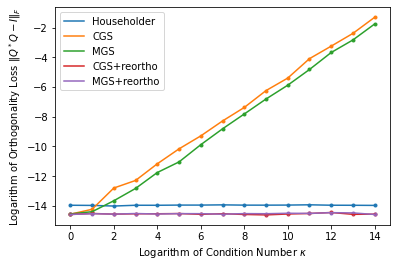

In [89]:
import matplotlib.pyplot as plt
for ortho in ortholoss:
    plt.plot(range(len(kappas)),np.log10(ortho))
    plt.scatter(range(len(kappas)),np.log10(ortho),marker='.')
plt.legend(['Householder','CGS','MGS','CGS+reortho','MGS+reortho'])
plt.xlabel('Logarithm of Condition Number $\kappa$')
plt.ylabel('Logarithm of Orthogonality Loss $\Vert Q^*Q - I\Vert_F$')
plt.show()


## References
1.  G. Golub and C. Van Loan, Matrix Computations, The Johns Hopkins University Press, Baltimore, Maryland, 4th ed., 2013.